# How to Carry Out Quantitative Analysis of Call Logs Using Qualtrics Data

Here I build on the [foundations we made using the PCH gmail inbox to quantitatively analyse our Helpline performance](https://github.com/TinasheMTapera/PCHGmail). Given that the helpline uses Qualtrics for it's call logs, the following functions can be used to analyse the data output.

First, we pull out the data in the zip file:

In [136]:
#imports
import zipfile
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pylab import *
import nltk
#nltk.download()
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
import gensim
from collections import Counter

plt.figure(figsize=(10,5))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

In [2]:
path_to_zip_file = "/Users/ttapera/Downloads/PCHdata.zip"

try:
    with zipfile.ZipFile(path_to_zip_file,"r") as zip_ref:
        zip_ref.extractall(".")
except IOError:
    print("Could not find the zip file.")

Next, we want to load the csv up into a pandas dataframe...

In [3]:
csv_path = "./PCH Call Log Test_February 24, 2018_18.51.csv"
try:
    qual = pd.read_csv(csv_path)
except IOError:
    print("Could not find the CSV.")

In [4]:
qual

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,body,skills,skills_7_TEXT,skills_8_TEXT,marketing,marketing_8_TEXT,referrals,referrals_7_TEXT,referrals_8_TEXT,couns_opinion
0,Start Date,End Date,Response Type,IP Address,Progress,Duration (in seconds),Finished,Recorded Date,Response ID,Recipient Last Name,...,Body of the call,What skills were used? - Selected Choice,What skills were used? - Other - Text,What skills were used? - Other - Text,How did the caller hear about the helpline? - ...,How did the caller hear about the helpline? - ...,What referrals were made? - Selected Choice,What referrals were made? - Other - Text,What referrals were made? - Other - Text,You may add any notes you would like to bring ...
1,"{""ImportId"":""startDate"",""timeZone"":""America/De...","{""ImportId"":""endDate"",""timeZone"":""America/Denv...","{""ImportId"":""status""}","{""ImportId"":""ipAddress""}","{""ImportId"":""progress""}","{""ImportId"":""duration""}","{""ImportId"":""finished""}","{""ImportId"":""recordedDate"",""timeZone"":""America...","{""ImportId"":""_recordId""}","{""ImportId"":""recipientLastName""}",...,"{""ImportId"":""QID13_TEXT""}","{""ImportId"":""QID16""}","{""ImportId"":""QID16_7_TEXT""}","{""ImportId"":""QID16_8_TEXT""}","{""ImportId"":""QID41""}","{""ImportId"":""QID41_8_TEXT""}","{""ImportId"":""QID42""}","{""ImportId"":""QID42_7_TEXT""}","{""ImportId"":""QID42_8_TEXT""}","{""ImportId"":""QID20_TEXT""}"
2,2018-02-24 18:45:46,2018-02-24 18:47:35,Survey Preview,NaN,100,108,True,2018-02-24 18:47:35,R_06CkdRy09Em91RL,NaN,...,body of call,"Validation,Normalization,Problem Solving",NaN,NaN,Posters,NaN,Counseling Center,NaN,NaN,notes for training
3,2018-02-24 18:47:40,2018-02-24 18:49:05,Survey Preview,NaN,100,84,True,2018-02-24 18:49:05,R_2AZs2obZ608bbPt,NaN,...,body of call,"Problem Solving,Silence,Redirection",NaN,NaN,Did not ask/unknown,NaN,No referrals made,NaN,NaN,notes for training
4,2018-02-24 18:49:08,2018-02-24 18:50:35,Survey Preview,NaN,100,87,True,2018-02-24 18:50:35,R_3HTwErx2KCxbt1l,NaN,...,test,"Problem Solving,Silence",NaN,NaN,Chalk the walk,NaN,"Counseling Center,Philadelphia Crisis Hotline,...",NaN,NaN,test
5,2018-02-24 18:50:38,2018-02-24 18:51:15,Survey Preview,NaN,100,37,True,2018-02-24 18:51:16,R_1LNZMjEEnAOMC4W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
'''
A few details. First, the first row is the data dictionary; we dont need that.
Additionally, we don't need surveys that were not completed; we use the "Finished" column to filter these.
'''

questions = qual.iloc[0,]
qual = qual.loc[qual["Finished"] == "True",]
qual.head()

,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,body,skills,skills_7_TEXT,skills_8_TEXT,marketing,marketing_8_TEXT,referrals,referrals_7_TEXT,referrals_8_TEXT,couns_opinion
2,2018-02-24 18:45:46,2018-02-24 18:47:35,Survey Preview,NaN,100,108,True,2018-02-24 18:47:35,R_06CkdRy09Em91RL,NaN,...,body of call,"Validation,Normalization,Problem Solving",NaN,NaN,Posters,NaN,Counseling Center,NaN,NaN,notes for training
3,2018-02-24 18:47:40,2018-02-24 18:49:05,Survey Preview,NaN,100,84,True,2018-02-24 18:49:05,R_2AZs2obZ608bbPt,NaN,...,body of call,"Problem Solving,Silence,Redirection",NaN,NaN,Did not ask/unknown,NaN,No referrals made,NaN,NaN,notes for training
4,2018-02-24 18:49:08,2018-02-24 18:50:35,Survey Preview,NaN,100,87,True,2018-02-24 18:50:35,R_3HTwErx2KCxbt1l,NaN,...,test,"Problem Solving,Silence",NaN,NaN,Chalk the walk,NaN,"Counseling Center,Philadelphia Crisis Hotline,...",NaN,NaN,test
5,2018-02-24 18:50:38,2018-02-24 18:51:15,Survey Preview,NaN,100,37,True,2018-02-24 18:51:16,R_1LNZMjEEnAOMC4W,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
qual.columns

Index(['StartDate', 'EndDate', 'Status', 'IPAddress', 'Progress',
       'Duration (in seconds)', 'Finished', 'RecordedDate', 'ResponseId',
       'RecipientLastName', 'RecipientFirstName', 'RecipientEmail',
       'ExternalReference', 'LocationLatitude', 'LocationLongitude',
       'DistributionChannel', 'UserLanguage', 'start_date', 'start_time_1',
       'start_time_2', 'start_time_3', 'end_date', 'end_time_1', 'end_time_2',
       'end_time_3', 'primary', 'secondary', 'answer', 'ask_student', 'm_f',
       'm_f_3_TEXT', 'Q22', 'student', 'primary_issues', 'secondary_issues',
       'body', 'skills', 'skills_7_TEXT', 'skills_8_TEXT', 'marketing',
       'marketing_8_TEXT', 'referrals', 'referrals_7_TEXT', 'referrals_8_TEXT',
       'couns_opinion'],
      dtype='object')

In [7]:
questions

StartDate                                                       Start Date
EndDate                                                           End Date
Status                                                       Response Type
IPAddress                                                       IP Address
Progress                                                          Progress
Duration (in seconds)                                Duration (in seconds)
Finished                                                          Finished
RecordedDate                                                 Recorded Date
ResponseId                                                     Response ID
RecipientLastName                                      Recipient Last Name
RecipientFirstName                                    Recipient First Name
RecipientEmail                                             Recipient Email
ExternalReference                                  External Data Reference
LocationLatitude         

# Basic Call Metrics

Now that we have the data in the session, we can run some basic call metric aggregation.

In [8]:
#number of calls
NUMCALLS=len(qual)
print("The phone rang " + str(NUMCALLS) + " times.")

The phone rang 4 times.


In [9]:
#percent of calls that cut before answered
ANSWERED=100-(len(qual.loc[qual["answer"] != "Yes",])/NUMCALLS)*100
print("We were able to respond to " + str(ANSWERED) + "% of the calls that came through.")

We were able to respond to 100.0% of the calls that came through.


In [10]:
#percent of calls that were Drexel students
NON_DREX=100-(len(qual.loc[qual["student"] != "Yes",])/NUMCALLS)*100
print(str(NON_DREX)+"% of the calls were Drexel Students.")

75.0% of the calls were Drexel Students.


In [11]:
#repeat callers
REPEATS=(len(qual.loc[qual["Q22"] == "Yes",])/NUMCALLS)*100
print("Approximately " + str(REPEATS) + "% of these calls are suspecteded repeat callers.")

Approximately 25.0% of these calls are suspecteded repeat callers.


In [12]:
#sex of callers
sex=qual.groupby(['m_f']).size().reset_index(name='count')
sex_bar = sns.barplot(y="m_f", x="count", data=sex)
sex_bar.set_ylabel("Sex", rotation="horizontal")
sex_bar.set_title("Perceived Sex of Our Callers")

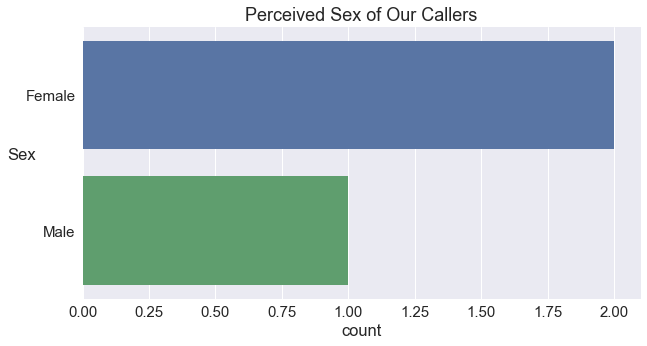

In [13]:
plt.show()

In [14]:
#primaries and secondaries
prim = qual.groupby(["primary"]).size().reset_index(name="Number_of_Calls")
prim_bar = sns.barplot(x="primary", y="Number_of_Calls", data=prim)
prim_bar.set_xlabel("Primary Counselor")
plt.xticks(rotation=30, ha='right')
prim_bar.set_title("Number of Calls As Primary")

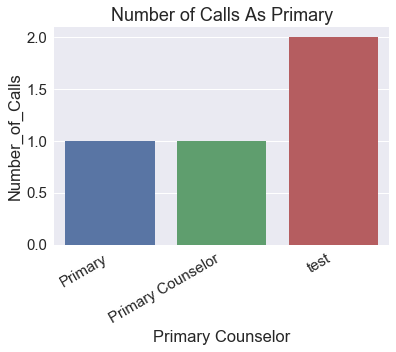

In [15]:
plt.show()

In [16]:
#primaries and secondaries
sec = qual.groupby(["secondary"]).size().reset_index(name="Number_of_Calls")
sec_bar = sns.barplot(x="secondary", y="Number_of_Calls", data=sec)
sec_bar.set_xlabel("Secondary Counselor")
plt.xticks(rotation=30, ha='right')
sec_bar.set_title("Number of Calls As Secondary")

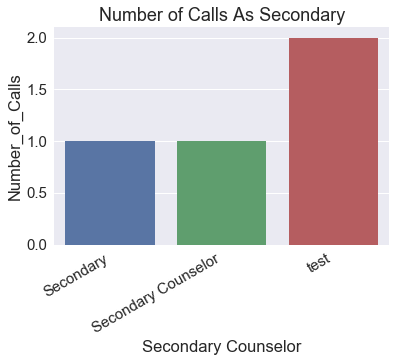

In [17]:
plt.show()

In [18]:
pairs = qual.groupby(["primary","secondary"]).size().reset_index(name="Number_of_Calls")
prims=pairs["primary"].values.tolist()
prims=[n.split()[0] for n in prims]
secs=pairs["secondary"].values.tolist()
secs=[n.split()[0] for n in secs]
pairs["Pair"]=[p+" & "+s for p,s in zip(prims,secs)]

pairs["prim_FN"] = pairs["primary"].values
pairs["Pair"]=pairs["primary"]+" & "+pairs["secondary"]
pairs_bar = sns.barplot(x="Pair", y="Number_of_Calls", data=pairs)
pairs_bar.set_xlabel("Pair")
plt.xticks(rotation=30, ha='right')
pairs_bar.set_title("Number of Calls As A Team")

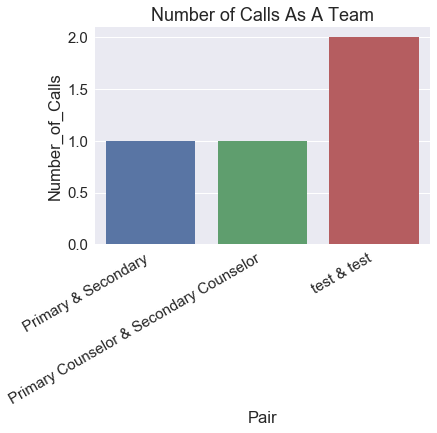

In [19]:
plt.show()

In [20]:
#analyse call start and end times. specifically, start by concatenating to create dt object
qual["Call_Start"]=pd.to_datetime(qual["start_date"] + " " + 
                                  qual["start_time_1"] + ":" + 
                                  qual["start_time_2"] + 
                                  qual["start_time_3"])

qual["Call_End"]=pd.to_datetime(qual["end_date"] + " " + 
                                  qual["end_time_1"] + ":" + 
                                  qual["end_time_2"] + 
                                  qual["end_time_3"])

#get more granular
qual["Date"]=qual["Call_Start"].dt.date
qual["Day"]=qual["Call_Start"].dt.dayofweek
qual["Hour"]=qual["Call_Start"].dt.dayofweek
qual["Duration"]=qual["Call_End"]-qual["Call_Start"]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [24]:
#plot calls over time
PAD = 3 #the number of days left or right to give the plot some room
qual["Date"] = pd.to_datetime(qual["Date"])
n_calls = qual.set_index('Date').resample("D", "count").Day
call_series=n_calls.plot(x_compat=True, title='Number of Calls Over Time')

minn = n_calls.index.min()-PAD
maxx = n_calls.index.max()+PAD

call_series.set_xlim(minn, maxx)
call_series.set_ylabel("Number of Calls")
call_series.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).count()
  after removing the cwd from sys.path.


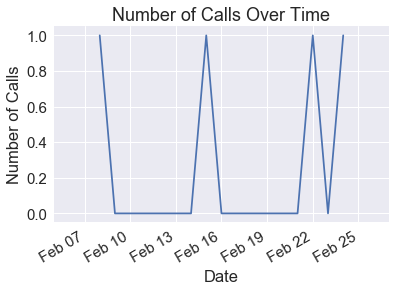

In [25]:
plt.show()

In [26]:
#plot calls per day of week

dow = qual.groupby(["Day"]).size().reset_index(name="Count")
dow = dow.replace({"Day" : {0:"Monday", 1:"Tuesday", 2:"Wednesday", 3:"Thursday", 4:"Friday", 5:"Saturday", 6:"Sunday"}})
dow_bar = sns.barplot(x="Day", y="Count", data=dow)
dow_bar.set_xlabel("Day_of_Week")
#plt.xticks(rotation=30, ha='right')
dow_bar.set_title("Number of Calls Per Day of Week")

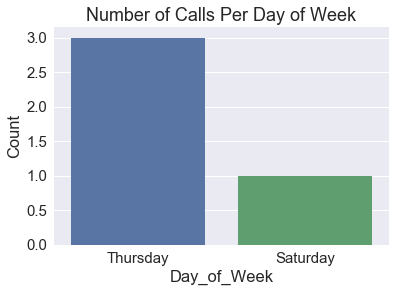

In [27]:
plt.show()

In [28]:
#histogram of durations
hist=sns.distplot(qual["Duration"]/pd.Timedelta(minutes=1),rug=True, kde=False)
hist.set_title("Histogram of Duration of Calls")

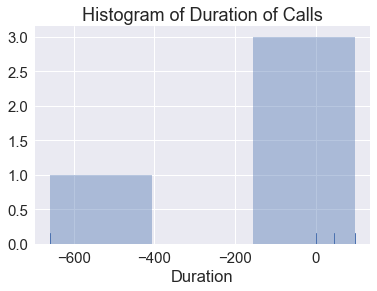

In [29]:
plt.show()

In [30]:
#marketing questions
marketing=qual.filter(regex=u".*marketing.*")

marketing_list = []

for i, row in marketing.iterrows():
    for val in row.values:
        if isinstance(val, str):
            if "," in val:
                marketing_list.extend(val.split(","))
            else:
                marketing_list.append(val)
    
marketing_list = dict([x,marketing_list.count(x)] for x in set(marketing_list))

marketing = pd.DataFrame(list(marketing_list.items()))
marketing.columns = marketing.columns.astype(str)
marketing = marketing.rename(columns={"0":"Method", "1":"Count"})

MARKETING_PERCENT=marketing.loc[marketing["Method"] == "Did not ask/unknown",]["Count"].values
MARKETING_PERCENT=(MARKETING_PERCENT[0]/len(qual.loc[qual["answer"] == "Yes",]))*100

print("We were able to ask about marketing information " + str(MARKETING_PERCENT) + "% of the time.")

We were able to ask about marketing information 25.0% of the time.


In [31]:
#plot marketing methods
marketing_bar = sns.barplot(x="Method", y="Count", data=marketing)
marketing_bar.set_title("Types of Marketing Reported by Callers")
plt.xticks(rotation=30, ha='right')

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

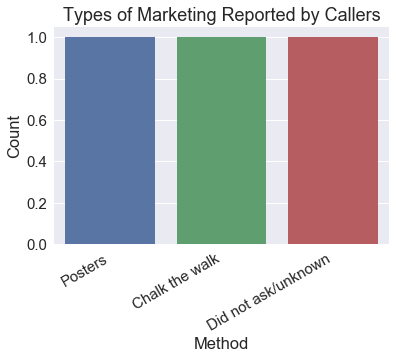

In [32]:
plt.show()

In [131]:
#gather marketing questions
referrals=qual.filter(regex=u".*referrals.*")

refs_list = []

for i, row in referrals.iterrows():
    for val in row.values:
        if isinstance(val, str):
            if "," in val:
                refs_list.extend(val.split(","))
            else:
                refs_list.append(val)
    
refs_list = dict([x,refs_list.count(x)] for x in set(refs_list))

refs = pd.DataFrame(list(refs_list.items()))
refs.columns = refs.columns.astype(str)
refs = refs.rename(columns={"0":"Referral", "1":"Count"})

#plot referrals
refs_bar = sns.barplot(x="Referral", y="Count", data=refs)
refs_bar.set_title("Referrals Made by Counselors")
plt.xticks(rotation=30, ha='right')
plt.figure(figsize=(10,7))

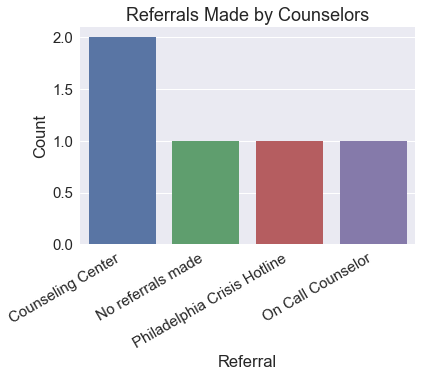

In [132]:
plt.show()

# Topic Model Analysis

Next, we use topic modeling to tell us about the content of our calls.

In [47]:
# create a list of call bodies
bodies = []

for i, row in qual.iterrows():
    try:
        bodies.append(row["body"])
    except:
        bodies.append("")
        
stops = [word for word in stopwords.words('english')]
stops.extend([WordNetLemmatizer().lemmatize(w) for w in stops])
stops.extend([PorterStemmer().stem(w) for w in stops])

In [48]:
#adding some dummy calls from the PCH training manual
bodies.append("I am a junior here and I am having a lot of trouble with my classes. "+
              "I have tried using a tutor, but I just can’t seem to get decent grades"+
              " in math or my English classes. My parents are flipping out about all of this and"+
              " I have no idea of what I should do next. In addition to all this my roommate"+
              " and I are constantly fighting. She is such a clean freak and I can’t keep up" +
              " with all of her rules and regulations")

bodies.append("I am a second semester freshman and first semester I went home every weekend"+
              " to be with my family. Now I am trying to get more involved on campus, but I"+
              " feel like I am running into a brick wall. I can’t find any good friends,"+
              " because most people made friends last term when I was at home. Even when I find "+
              "people I like, they are too busy with their groups of friends that they don’t" +
              " have time to spend with me. I feel really lonely and I am mad at myself for not making friends sooner.")

bodies.append("I can’t stop thinking about my best friend from home who died before we left for college."+
              " It was a car accident, and I keep replaying it over and over again in my head. "+
              "Even when I am in a good mood, something will remind me about it and I will get depressed again. "+
              "I can’t believe that she is gone.")

bodies.append("I am calling because my friends are always bugging me about what I eat. I told them that I would"+
              " call and talk to someone about it. I don’t always eat as much as other people, but " +
              "usually it is because I am just not hungry.  I try to take care of myself and eat things" +
              " that are low-fat. Do you think I have an eating disorder?")

bodies.append("There are a lot of things that are going on in my life right now and I am not " +
              "sure where to turn. I go out a lot and drink with my friends and roommate, but " +
              "lately my roommate has been really difficult. He is always fighting with his " +
              " girlfriend and I can’t get to sleep. Usually I am drunk when this happens and " +
              "then I blow up at him. It is really awkward in the mornings after I have flipped out." + 
              "I usually apologize to him for being so mean, but it has been happening more and more. " +
              "I drink so that I don’t have to think about my roommate situation. I also am having " +
              "trouble paying my bills and getting to work on time.")

bodies.append("I do not feel like I belong at school, it has already been 2 months and I" +
              " haven’t found any good friends. No one on my hall really likes me and they " +
              "don’t share my interests. I don’t know what I should do; can you tell me what " +
              "I should be doing to make friends here? ")

bodies.append("I am not really sure that I should be calling, because I don’t know if I have a"+
              " problem. I go out a lot and drink, and I don’t know if I am an alcoholic or not." +
              " I wanted to see what you thought about my drinking")

bodies.append("I am a freshman here, and I am calling because I am not doing too well in school." +
              " I am not sure what I should do, because I can’t talk to my parents" +
              " about my problems. Not only are my grades not good, but I also feel really lonely here." +
              " When I was in high school I had lots of friends and now I just can’t find" +
              " the group that I fit in with. My roommate was cool at first and now all we do" +
              " is fight. We are just two totally different people and he/she doesn’t understand me")

bodies.append("I don’t know what to do. Things are so expensive at Drexel "+
              "and my financial aid is getting cut because I’m not doing as "+
              "well as I’m supposed to. And now I won’t be able to pay my "+
              "rent because I’m losing my scholarship. I can’t tell my parents " +
              "about how badly I’m doing because they will pull me out of school. I don’t know what I can do")

bodies.append("I am not sure what to do, my life is over. I have been upset about my life"+
              " and my family for a long time, and there is nothing that I can do to"+
              " solve my problems. I don’t think I can stand it much longer.")

In [49]:
bodies

['body of call',
 'body of call',
 'test',
 nan,
 'I am a junior here and I am having a lot of trouble with my classes. I have tried using a tutor, but I just can’t seem to get decent grades in math or my English classes. My parents are flipping out about all of this and I have no idea of what I should do next. In addition to all this my roommate and I are constantly fighting. She is such a clean freak and I can’t keep up with all of her rules and regulations',
 'I am a second semester freshman and first semester I went home every weekend to be with my family. Now I am trying to get more involved on campus, but I feel like I am running into a brick wall. I can’t find any good friends, because most people made friends last term when I was at home. Even when I find people I like, they are too busy with their groups of friends that they don’t have time to spend with me. I feel really lonely and I am mad at myself for not making friends sooner.',
 'I can’t stop thinking about my best frien

In [139]:
#tranform bodies to a corpus of tokens
corpus = []
for b in bodies:
    try:
        ex=re.sub(r"[^\w\s]", "",b)
        ex=ex.lower()
        if len(ex) > 1:
            ex=ex.split()
        else:
            ex=[ex]
        corpus.append(ex)
    except:
        continue
        

#corpus = [PorterStemmer().stem(w) for w in corpus]

In [143]:
#get the common words in the corpus
wordcount = [item for items in corpus for item in items]
wordcount = [w for w in wordcount if w not in stops]
wordcount = [WordNetLemmatizer().lemmatize(w) for w in wordcount]
wordcount = Counter(wordcount).most_common()
print(str(len(wordcount)) + " common words")
print(wordcount[:50])

179 common words
[('friend', 10), ('dont', 10), ('cant', 9), ('really', 6), ('lot', 5), ('roommate', 5), ('know', 5), ('get', 4), ('feel', 4), ('like', 4), ('good', 4), ('people', 4), ('sure', 4), ('school', 4), ('im', 4), ('call', 3), ('parent', 3), ('home', 3), ('find', 3), ('time', 3), ('calling', 3), ('always', 3), ('eat', 3), ('usually', 3), ('thing', 3), ('think', 3), ('life', 3), ('drink', 3), ('problem', 3), ('body', 2), ('trouble', 2), ('class', 2), ('grade', 2), ('fighting', 2), ('keep', 2), ('semester', 2), ('freshman', 2), ('first', 2), ('family', 2), ('even', 2), ('group', 2), ('lonely', 2), ('talk', 2), ('much', 2), ('go', 2), ('also', 2), ('getting', 2), ('tell', 2), ('well', 2), ('test', 1)]


In [144]:
# plot these words
wc = pd.DataFrame(wordcount)
wc = wc.rename(index=str, columns={0:"Word", 1:"Count"})
wc.set_index("Word")

wc.iloc[:25,].plot(x="Word", y="Count", kind="barh", figsize=(10,7), legend=None)
plt.title("Top 25 Words in Recent Call Logs")
plt.xlabel("Count")

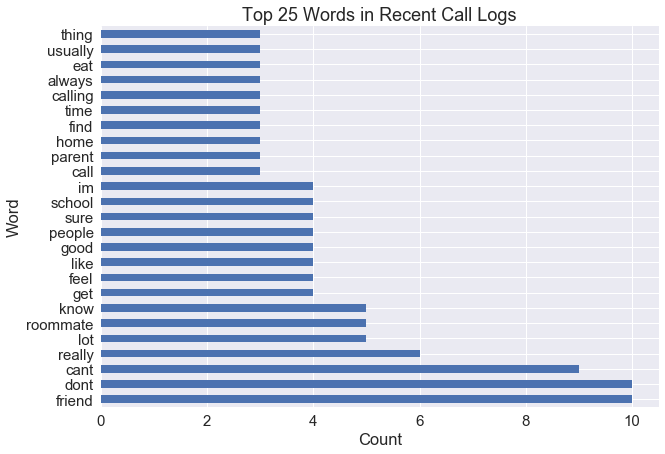

In [145]:
plt.show()

In [163]:
print(corpus)

[['body', 'of', 'call'], ['body', 'of', 'call'], ['test'], ['i', 'am', 'a', 'junior', 'here', 'and', 'i', 'am', 'having', 'a', 'lot', 'of', 'trouble', 'with', 'my', 'classes', 'i', 'have', 'tried', 'using', 'a', 'tutor', 'but', 'i', 'just', 'cant', 'seem', 'to', 'get', 'decent', 'grades', 'in', 'math', 'or', 'my', 'english', 'classes', 'my', 'parents', 'are', 'flipping', 'out', 'about', 'all', 'of', 'this', 'and', 'i', 'have', 'no', 'idea', 'of', 'what', 'i', 'should', 'do', 'next', 'in', 'addition', 'to', 'all', 'this', 'my', 'roommate', 'and', 'i', 'are', 'constantly', 'fighting', 'she', 'is', 'such', 'a', 'clean', 'freak', 'and', 'i', 'cant', 'keep', 'up', 'with', 'all', 'of', 'her', 'rules', 'and', 'regulations'], ['i', 'am', 'a', 'second', 'semester', 'freshman', 'and', 'first', 'semester', 'i', 'went', 'home', 'every', 'weekend', 'to', 'be', 'with', 'my', 'family', 'now', 'i', 'am', 'trying', 'to', 'get', 'more', 'involved', 'on', 'campus', 'but', 'i', 'feel', 'like', 'i', 'am', 

In [159]:
# LDA topic model with Topics nTOPICS
nTOPICS=3
dictionary = gensim.corpora.Dictionary(corpus)
corpusMatrix = [dictionary.doc2bow(text) for text in corpus]
Lda = gensim.models.ldamodel.LdaModel
model = Lda(corpusMatrix, num_topics=nTOPICS, id2word = dictionary, passes=100)

/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:995: RuntimeWarning: invalid value encountered in subtract
  result = psi(alpha) - psi(np.sum(alpha))
/anaconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:609: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [162]:
p = model.top_topics(corpusMatrix)
topics = pd.DataFrame(columns=['Weight','Word','Topic'])

for i in range(len(p)):
    for j in range(len(p[i][0])):
        line = p[i][0][j]
        update = {"Weight":line[0], "Word":line[1], "Topic":chr(i)}
        topics = topics.append(update, ignore_index=True)
#topics["Weight"] = round(topics["Weight"],3).fillna(0)
topics.head()

,Weight,Word,Topic
0,NaN,has, 
1,NaN,so, 
2,NaN,he, 
3,NaN,awkward, 
4,NaN,happens, 
